Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Import data

In [3]:
data = pd.read_csv('../data/num_file/min_05/p040.csv')

In [4]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:45:00      0
2      2022-04-21 01:50:00    241
3      2022-04-21 01:55:00    592
4      2022-04-21 02:00:00     27
...                    ...    ...
38995  2022-09-03 11:15:00   1042
38996  2022-09-03 11:20:00   1913
38997  2022-09-03 11:25:00   2024
38998  2022-09-03 11:30:00   2006
38999  2022-09-03 11:35:00   2170

[39000 rows x 2 columns]


If there is no people, use NaN.

In [5]:
data.loc[data['count']==0, 'count'] = np.NaN

In [6]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:45:00     NaN
2      2022-04-21 01:50:00   241.0
3      2022-04-21 01:55:00   592.0
4      2022-04-21 02:00:00    27.0
...                    ...     ...
38995  2022-09-03 11:15:00  1042.0
38996  2022-09-03 11:20:00  1913.0
38997  2022-09-03 11:25:00  2024.0
38998  2022-09-03 11:30:00  2006.0
38999  2022-09-03 11:35:00  2170.0

[39000 rows x 2 columns]


<Axes: >

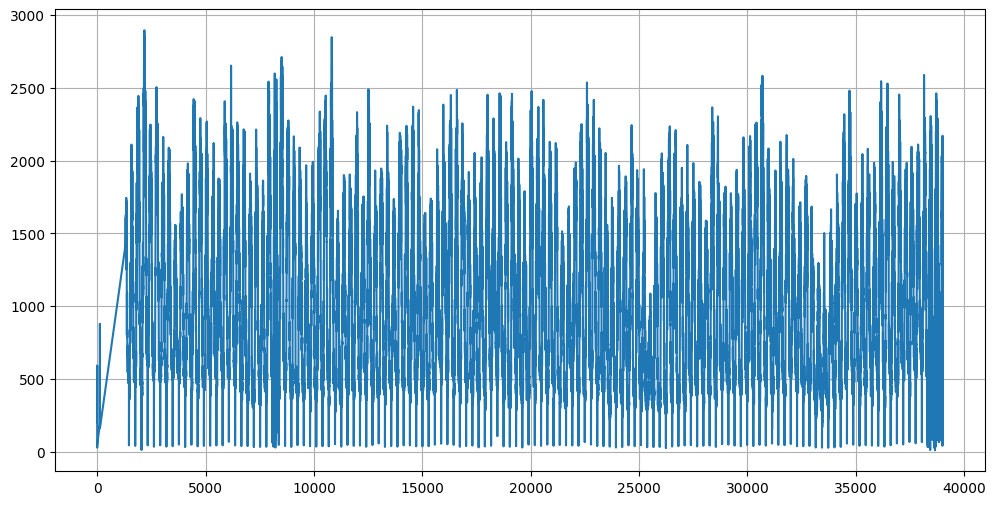

In [7]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

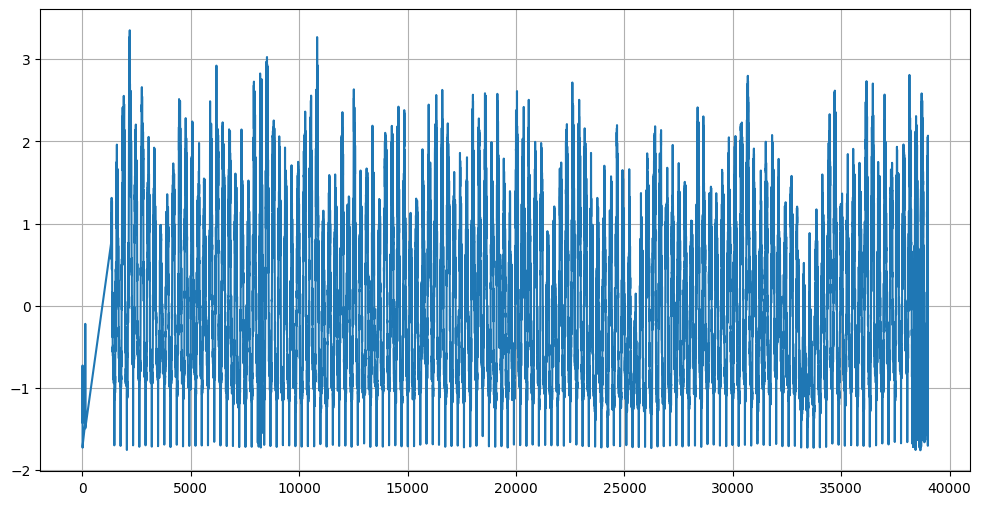

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [9]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.420353
1      2022-04-21 01:45:00 -1.384071
2      2022-04-21 01:50:00 -1.347789
3      2022-04-21 01:55:00 -0.726571
4      2022-04-21 02:00:00 -1.726537
...                    ...       ...
38995  2022-09-03 11:15:00  0.069861
38996  2022-09-03 11:20:00  1.611400
38997  2022-09-03 11:25:00  1.807854
38998  2022-09-03 11:30:00  1.775996
38999  2022-09-03 11:35:00  2.066252

[39000 rows x 2 columns]


In [10]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 12

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [11]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [12]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [13]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation, GRU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [14]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [15]:
# encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, activation='relu', return_sequences=True, return_state=True)(input_train)
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 12, 32), dtype=tf.float32, name=None), name='lstm/PartitionedCall:1', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm/PartitionedCall:2', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm/PartitionedCall:3', description="created by layer 'lstm'")


In [16]:
encoder_last_h = BatchNormalization()(encoder_last_h)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [17]:
decoder_input = RepeatVector(time_step)(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 12, 32), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [18]:
# decoder_stack_h = LSTM(32, activation='relu', return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
decoder_stack_h = LSTM(32, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 12, 32), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:1', description="created by layer 'lstm_1'")


In [19]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])

In [20]:
attention = Activation('relu')(attention)

In [21]:
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12), dtype=tf.float32, name=None), name='activation/Relu:0', description="created by layer 'activation'")


In [22]:
context = dot([attention, encoder_stack_h], axes=[2, 1])
context = BatchNormalization()(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 12, 32), dtype=tf.float32, name=None), name='batch_normalization_2/batchnorm/add_1:0', description="created by layer 'batch_normalization_2'")


In [23]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 12, 64), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [24]:
out = TimeDistributed(Dense(1))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 12, 1), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [25]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 12, 32),     4352        ['input_1[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization (BatchNorm  (None, 32)          128         ['lstm[0][1]']                   
 alization)                                                                                   

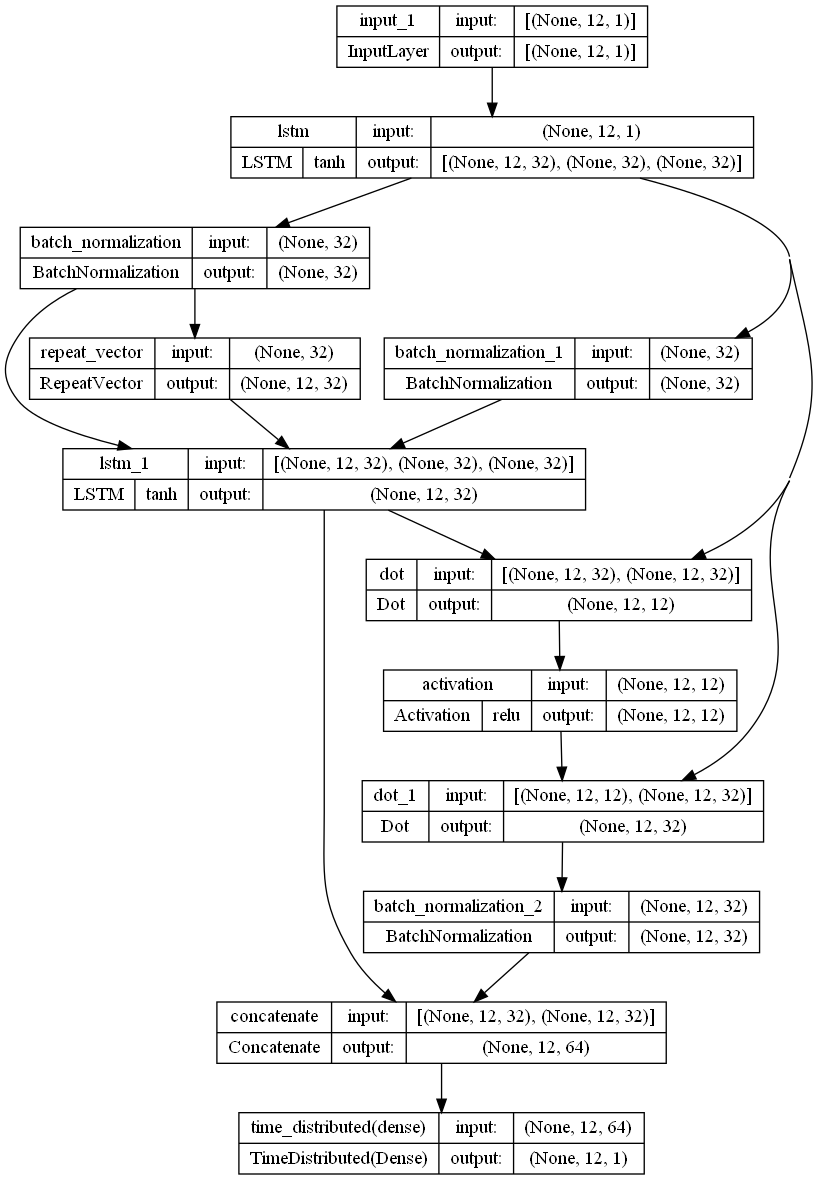

In [26]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_activations=True)

In [27]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
220/220 [==============================] - 5s 11ms/step - loss: 0.0564 - mae: 0.1549 - val_loss: 0.0818 - val_mae: 0.2185
Epoch 2/100
220/220 [==============================] - 2s 8ms/step - loss: 0.0360 - mae: 0.1358 - val_loss: 0.0284 - val_mae: 0.1221
Epoch 3/100
220/220 [==============================] - 2s 8ms/step - loss: 0.0308 - mae: 0.1246 - val_loss: 0.1238 - val_mae: 0.2570
Epoch 4/100
220/220 [==============================] - 2s 7ms/step - loss: 0.0284 - mae: 0.1189 - val_loss: 0.0245 - val_mae: 0.1121
Epoch 5/100
220/220 [==============================] - 2s 7ms/step - loss: 0.0250 - mae: 0.1108 - val_loss: 0.0524 - val_mae: 0.1495
Epoch 6/100
220/220 [==============================] - 2s 7ms/step - loss: 0.0223 - mae: 0.1036 - val_loss: 0.0230 - val_mae: 0.1168
Epoch 7/100
220/220 [==============================] - 2s 7ms/step - loss: 0.0215 - mae: 0.1025 - val_loss: 0.0238 - val_mae: 0.1112
Epoch 8/100
220/220 [==============================] - 2s 8ms/step -

In [28]:
# model.save('./params/p040_seq2seq_at.keras')

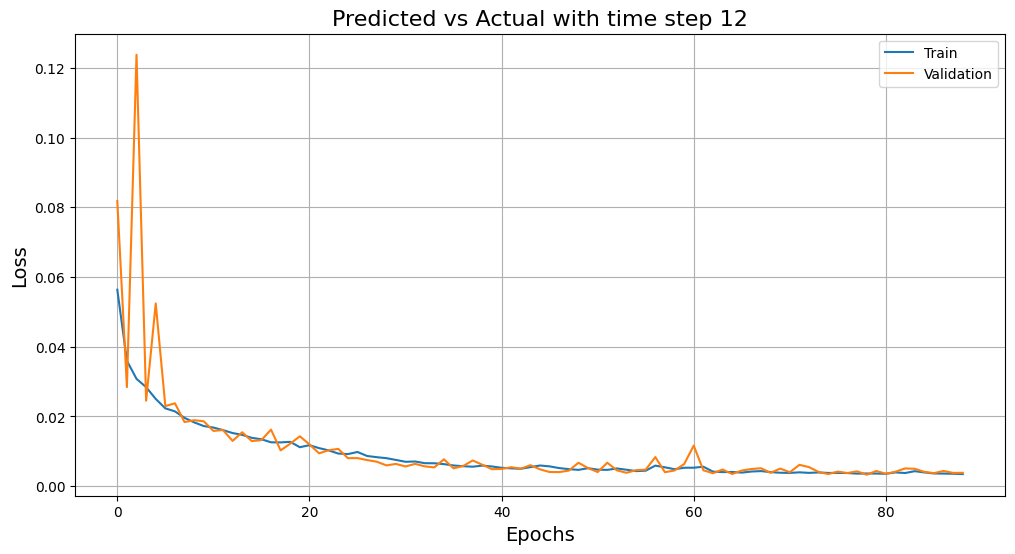

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [30]:
predict_test = model.predict(encode_input_data_test)

244/244 [==============================] - 1s 2ms/step


In [31]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

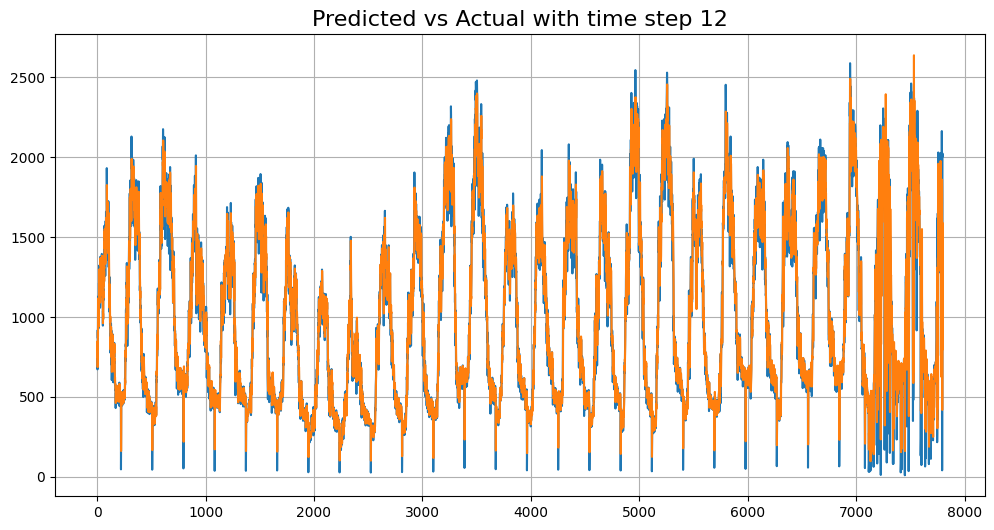

In [39]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'Predicted vs Actual with time step {time_step}')
plt.show()

In [33]:
print(predict_test_data)

[[ 753.0507 ]
 [ 846.5289 ]
 [ 780.67474]
 ...
 [1224.0835 ]
 [1589.886  ]
 [ 798.6907 ]]


In [34]:
print(decode_output_test_data)

[[ 818.]
 [ 735.]
 [ 770.]
 ...
 [1913.]
 [2024.]
 [2006.]]


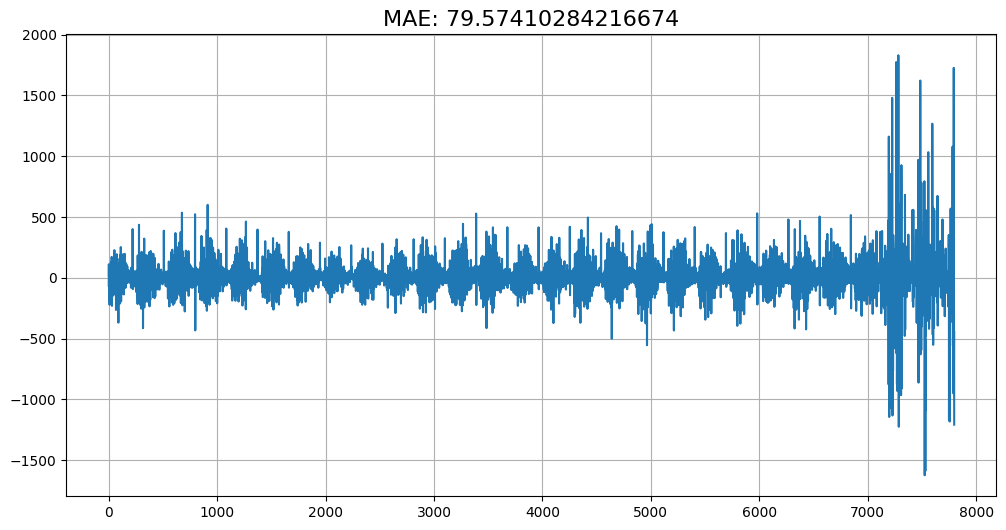

In [37]:
from sklearn.metrics import mean_absolute_error
plt.title('MAE: {}'.format(mean_absolute_error(decode_output_test_data, predict_test_data)))
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

79.57410284216674
